# Mind Optimizers
* Harish Iniyarajan
* Neha Sharma
* Vrishbhanu Singh
* Ishan Sahu

# Introduction
The goal of this project is to clasify the emotion expressed by a person based on their facial features in an image. While expressions are usually good indicators of emotions, they are not always accurate. Any bias that may be observed in the model is unintended.

We have also experimented with blending images of different emotions to create new ones, which are exciting and interesting. These are achieved using variational autoencoders and are explained later.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing necessary packages
!pip install tf-keras-vis tensorflow
!pip install visualkeras

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import cm, animation
import pandas as pd
import numpy as np
import os
import shutil
import sys
from glob import glob
import matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import visualkeras
import pathlib
from google.colab import files

# 1. Loading and processing the data

In [ ]:
# Directory where the dataset is to be present
Dir_main = "drive/MyDrive/AI-2 Project"

# The download link of the dataset
dataset = '1nvCb84mMwUuP0_U0oqZjJq4QlcfSvdoy'

In [ ]:
# Creating main directory if it is not present
try: 
  if os.path.isdir(Dir_main):
    print("Main directory is already present")
  else:
    try:
      os.mkdir(Dir_main)
    except:
      print("Directory not found and could not create directory")
except:
  print("Could not check the presence of main directory")

Main directory is already present


In [ ]:
# Function to create train, test and validation split of the dataset
def train_test_split(root_dir,dest_dir, test_ratio, val_ratio):
  """
  Function to create train, test and validation splits

  Parameters:
  ----------
  arg1: String
      The path to root directory with different classes
  arg2: String
      The path of the folder in which train, test and validation images are to be stored
  arg3: float
      The ratio of dataset which is to be segregated as test set
  arg4: float
      The ratio of dataset which is to be segregated as validation set
  """
  print("########### Train Test Val Script started ###########")

  # Folder check 
  if not os.path.isdir(dest_dir):
    os.makedirs(dest_dir)
  classes_dir = os.listdir(root_dir)

  print(classes_dir)
  for cls in classes_dir:
      # Creating partitions of the data after shuffeling
      print("$$$$$$$ Class Name " + cls + " $$$$$$$")
      src = os.path.join(root_dir,cls)  # Folder to copy images from
      allFileNames = os.listdir(src)
      np.random.shuffle(allFileNames)
      train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                  int(len(allFileNames) * (1 - val_ratio)),
                                                                  ])
      print(allFileNames)
      train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
      val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
      test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

      print('Total images: '+ str(len(allFileNames)))
      print('Training: '+ str(len(train_FileNames)))
      print('Validation: '+  str(len(val_FileNames)))
      print('Testing: '+ str(len(test_FileNames)))

      # # Creating Train / Val / Test folders (One time use)
      if not os.path.isdir(dest_dir+'/train/'+cls):
        os.makedirs(dest_dir + '/train/' + cls)
      if not os.path.isdir(dest_dir + '/val/' + cls):
        os.makedirs(dest_dir + '/val/' + cls)
      if not os.path.isdir(dest_dir + '/test/' + cls):
        os.makedirs(dest_dir + '/test/' + cls)

      print(train_FileNames, val_FileNames, test_FileNames)
      # Copy-pasting images
      if len(os.listdir(dest_dir+"/train/"+cls))==0:
        for name in train_FileNames:

          basename=os.path.basename(name)
          final_dest=dest_dir+'/train/'+cls+'/'+basename
          if os.path.exists(final_dest):
            print(os.path.exists(final_dest))
          else:
            print(f'copying {name} to {final_dest}')
            !cp "$name"  "$final_dest"
            # shutil.copy(name, final_dest)

      if len(os.listdir(dest_dir+"/val/"+cls))==0:
        for name in val_FileNames:
          basename=os.path.basename(name)
          final_dest=dest_dir+'/val/'+cls+'/'+basename
          if os.path.exists(final_dest):
            print(os.path.exists(final_dest))
          else:
            print(f'copying {name} to {final_dest}')
            !cp "$name"  "$final_dest"
            # shutil.copy(name, final_dest)
      if len(os.listdir(dest_dir+"/test/"+cls))==0:
        for name in test_FileNames:
          basename=os.path.basename(name)
          final_dest=dest_dir+'/test/'+cls+'/'+basename
          if os.path.exists(final_dest):
            print(os.path.exists(final_dest))
          else:
            print(f'copying {name} to {final_dest}')
            # shutil.copy(name, final_dest)
            !cp "$name"  "$final_dest"

  print("########### Train Test Val Script Ended ###########")

In [ ]:
# Function to download and unzip the file
def unzip(file_link, file_name, unzipped_file_name, destination_path):
  """
  Downloads the file at a given link and unzips it.

  Parameters:
  ----------
  arg1: String
      The download link of the file
  arg2: String
      The name of the file
  arg3: String
      The name that the file should have after unzipping
  arg4: String
      The destination path at which the downloaded file is to be stored
  """
  if os.path.isdir(os.path.join(destination_path, unzipped_file_name)):
    print('unzip folder already exists')
  else:
    print('file not found, going to download now ', os.path.join(destination_path, unzipped_file_name))
    try:
          !gdown "$file_link"
          try:
            !unzip "$file_name"  -d  "$destination_path"
            print('unzip successful')
          except:
            print("something went wrong with unzipping")
    except:
          print('something went wrong when downloading dataset')

In [ ]:
# Function to faciliate file copying
def move_file(old_file_path, new_directory):
  """
  Moves a file from old directory to new directory

  Parameters:
  -----------
  arg1: String
      The path of old files
  arg2: String
      The path of new files
  """
  new_dir=os.path.dirname(new_directory)
  if not os.path.isdir(new_dir):
      os.mkdir(new_dir)
  base_name = os.path.basename(old_file_path)
  new_file_path = os.path.join(new_directory, base_name)
  # Deletes a file if that file already exists there, you can change this behavior
  if not os.path.exists(new_file_path):
    !cp "$old_file_path" "$new_file_path"
    print(f'file copied from {old_file_path} to {new_file_path}')

In [ ]:
# Creating a data generator
data_generator=ImageDataGenerator()


  # Inputs:
    # Directory name where the images are stored
    # batch_size
    # target_size i.e. to resize the images
    # color_mode. One of "grayscale", "rgb", "rgba"
    # class_mode "binary" or "categorical"
# Function to help create data generators
def augmentation(directory_name, batch_size=32, target_size=(240,240) , color_mode="grayscale", class_mode="categorical"):
  """
  Creating an ImageDataGenerator from a given directory

  Parameters:
  ----------
  arg1: String
      The directory path where the images are stored
  arg2: int
      The desired batch size
  arg3: tuple of int
      The target image dimensions
  arg4: String
      The color_mode of the target images. One of "grayscale", "rgb", "rgba". Default is "grayscale"
  arg5: String
      The class_mode. One of "categorical", "binary", "sparse", "input" or None. Default is "categorical"

  Returns:
  -------
  arg1: DirectoryIterator
      A DirectoryIterator of tuples (x,y) with images in x and labels in y.
  """
  generator = data_generator.flow_from_directory(
    directory= directory_name,
    batch_size= 32,
    target_size= (240,240),
    color_mode= 'grayscale',
    class_mode= 'categorical'
)
  return generator

In [ ]:
# Unzipping the data set
unzip(dataset, 'facial_expressions-master', 'facial_expressions-master', Dir_main)

unzip folder already exists


In [ ]:
## The dataset contians images and a legend which maps the images to the expression.
## It is therefore necessary to create new folders based on their class labels and 
## move the images to their respective folders.

# Making folders for the dataset
df = pd.read_csv(Dir_main+"/facial_expressions-master/data/legend.csv", header=None, skiprows=1)

# Converting everything to lowerCase
df[2]=df[2].str.lower()

# Preprocessing some class labels
df[2].mask(df[2] == 'neutral', 'neutrality', inplace=True)


# Copying files into another folder based on category
copy_main = Dir_main+"/facial_expressions-master/images/"

dest_main=Dir_main+"/facial_expressions_classified"

for index, row in df.iterrows():

    if not os.path.isdir(dest_main):
      os.mkdir(dest_main)
    filename = os.path.join(copy_main, row[1])
    destination_folder=dest_main+"/"+row[2]+"/"
    move_file(filename, destination_folder)
    print("Done for " + row[1])

In [ ]:
# Splitting the dataset

train_test_split(Dir_main+'/facial_expressions_classified/',Dir_main+'/data',0.1, 0.2)

In [ ]:
# Getting the data generators for the dataset

data_train_gen=augmentation(Dir_main+"/data/train")
data_test_gen=augmentation(Dir_main+"/data/test")
data_val_gen=augmentation(Dir_main+"/data/val")

Found 9574 images belonging to 8 classes.
Found 2740 images belonging to 8 classes.
Found 1369 images belonging to 8 classes.


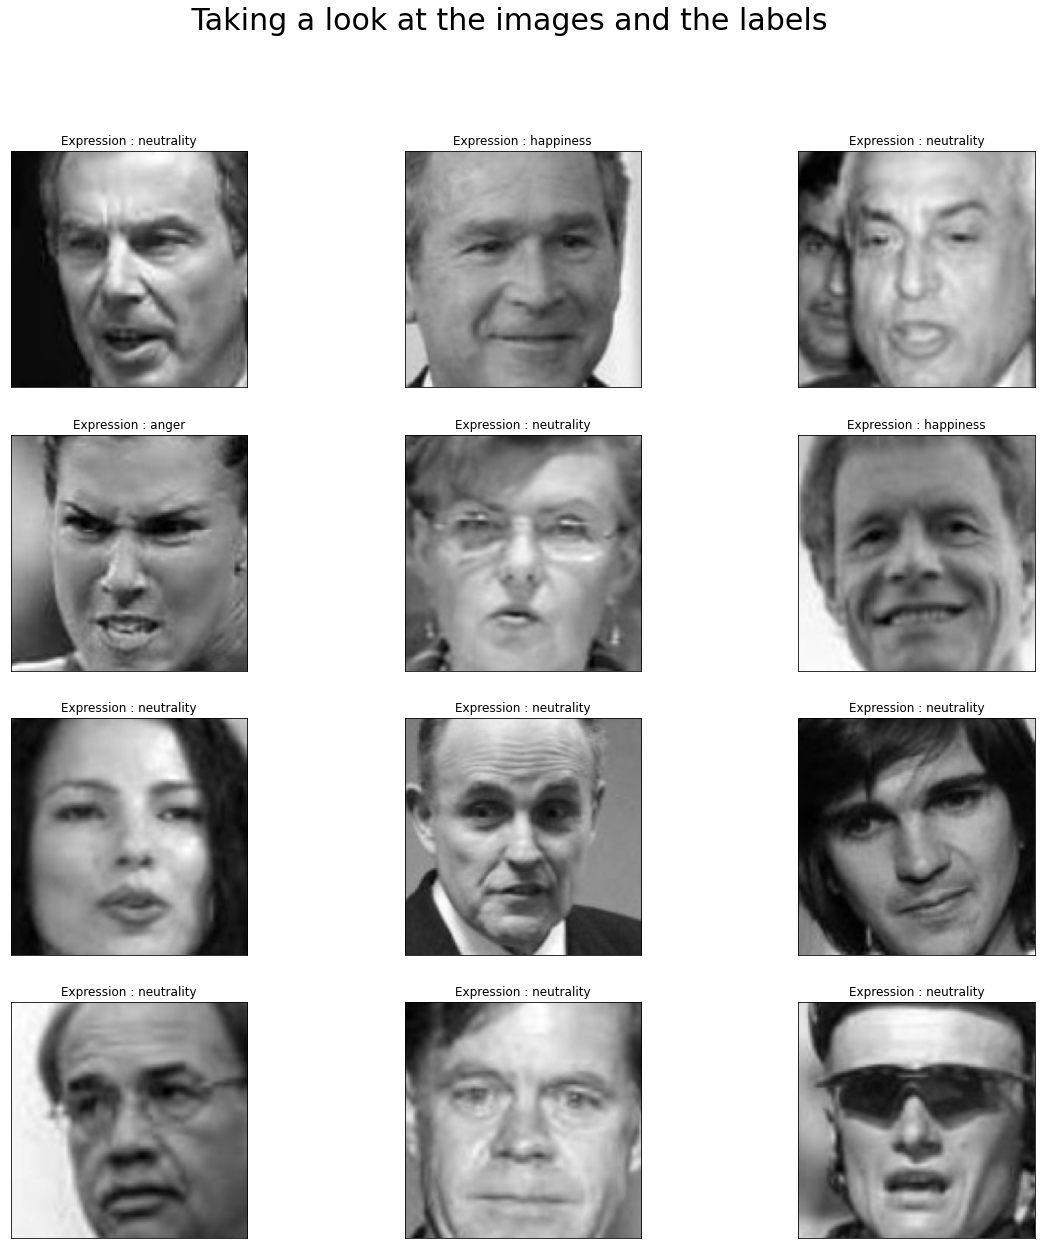

In [ ]:
# Taking a quick look at the images and their labels

# Getting the class labels
Label_dict = list(data_train_gen.class_indices.keys())

# Creating iterators out of one batch
image_iterator = iter(data_train_gen[0][0])
label_iterator = iter(data_train_gen[0][1])

# Plotting this small sample of images
f, axarr = plt.subplots(4,3, figsize = (20,20))

f.suptitle(' Taking a look at the images and the labels', fontsize=30)

# Looping through the rows 
for i in range(4):

  # Looping thorugh the columns
  for j in range(3):

    # Getting the image and the label
    img_vis = (image_iterator.__next__()).squeeze()
    label = label_iterator.__next__()
    label_vis = Label_dict[np.argmax(label)]

    # Plotting the images
    axarr[i,j].imshow(img_vis, cmap="gray")
    axarr[i,j].set_title(f'Expression : {(label_vis)}')
    axarr[i,j].get_xaxis().set_visible(False)
    axarr[i,j].get_yaxis().set_visible(False)

plt.show()

## 1.1 Helper functions

In [ ]:
# Helper function to plot Saliency map and GradCAM
def plot_saliency_cam(model, image, label):
  """
  Plots Saliency map and GradCAM

  Parameters:
  ----------
  arg1: model
      The NN that the images are trained on
  arg2: image (240x240x1)
      The image for which Saliency map GradCAM are to be plotted
  arg3: label
      One-hot encoded true prediction label. Used in score function
  """
  # Creating a model modifier
  replace2linear = ReplaceToLinear()

  # Getting the score to be used in Saliency map and GradCAM
  score = CategoricalScore(np.argmax(label))

  # Getting the Saliency map
  saliency = Saliency(model, model_modifier = replace2linear, clone = True)
  saliency_map = saliency(score, image)

  # Getting the GradCAM
  gradcam = Gradcam(model, model_modifier = replace2linear, clone = True)
  cam = gradcam(score, image)

  # Plotting the Saliency map and GradCAM along with the input image
  fig, axs = plt.subplots(1, 3, figsize=(15,5))

  axs[0].imshow(np.squeeze(image), cmap='gray')
  axs[0].set_title("Input image")
  axs[0].axis('off')

  axs[1].imshow(np.squeeze(saliency_map))
  axs[1].set_title("Saliency map")
  axs[1].axis('off')

  axs[2].imshow(np.squeeze(cam))
  axs[2].set_title("GradCAM")
  axs[2].axis('off')

  plt.show()
  return

In [ ]:
# Helper function to get feature maps
def get_feature_maps(model, layer_id, input_image):
    """
    Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
    ----------
    arg1: tf.keras.Model
        Model to examine
    arg2: int
        The layer index for feature map generation
    arg3: NumPy ndarray
        The input image

    Returns:
    --------
    arg1: list[ndarray]
        Feature map stack of the specific layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    feature_map = model_(input_image)
    return feature_map

# 2.Creating a custom model

In [ ]:
# Creating the custom model
custom_model = Sequential()

# Adding the layers
custom_model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="valid", input_shape=(240,240,1)))
custom_model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="valid"))
custom_model.add(MaxPool2D(pool_size=(2,2)))

custom_model.add(Conv2D(128, kernel_size=(3,3), activation="relu", padding="valid"))
custom_model.add(Conv2D(128, kernel_size=(3,3), activation="relu", padding="valid"))
custom_model.add(MaxPool2D(pool_size=(2,2)))

custom_model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding="valid"))
custom_model.add(MaxPool2D(pool_size=(2,2)))

custom_model.add(Conv2D(512, kernel_size=(3,3), activation="relu", padding="valid"))
custom_model.add(MaxPool2D(pool_size=(2,2)))

custom_model.add(Flatten())
custom_model.add(Dense(64, activation='relu'))

# Output layer
custom_model.add(Dense(8, activation='softmax'))

# Viewing the summary of the model
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 114, 114, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 57, 128)      0         
 2D)                                                    

After experimenting with multiple model architecture, we found the current architecture to be among the best ones. It performed better more deeper and complex architectures as well.

In [ ]:
# Compiling the model
custom_model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics="accuracy")

In [ ]:
# Checking if model weights are present, to avoid training every time.
if os.path.isfile("custom_model.h5"):
  # Loading the trained weights
  custom_model.load_weights("custom_model.h5")

else:
  # Defining Early Stopping criteria
  early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

  # Training the  custom model
  custom_history = custom_model.fit(data_train_gen, validation_data=data_val_gen, epochs=20, verbose=0, workers=8, callbacks=early_stop)

  # Saving the custom model weights
  custom_model.save_weights("custom_model.h5")

In [ ]:
# Checking the model performance on test data
custom_test_accuracy = custom_model.evaluate(data_test_gen, workers=8)[1]
print(f"The test accuracy of custom model is: {custom_test_accuracy: .4f}")

86/86 [==============================] - 700s 8s/step - loss: 0.4223 - accuracy: 0.8591
The test accuracy of custom model is:  0.8591


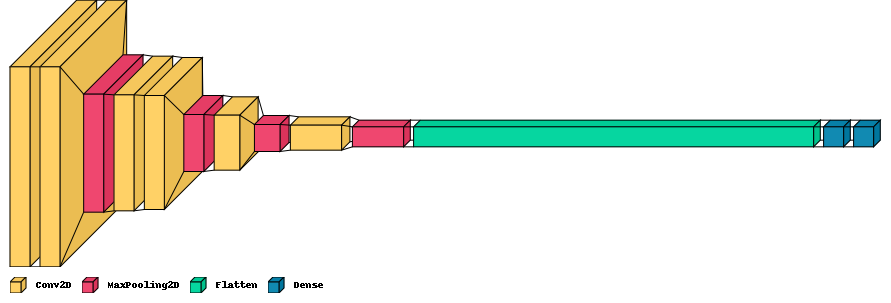

In [ ]:
# Viewing the model architecture
visualkeras.layered_view(custom_model, legend=True, max_xy=200, scale_xy=1)

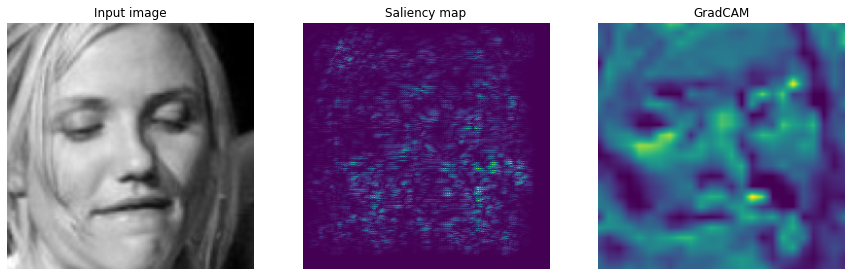

In [ ]:
# Visualizing Saliency map and GradCAM for a test image
plot_saliency_cam(custom_model, data_test_gen[0][0][0], data_test_gen[0][1][0])

The Saliency map and GradCAM pickup the areas below the eyes, on the cheek and near the mouth. Areas above the eyes seem to play some role too. These are important features which change with facial expressions and they have been captured well.

# 3.Transfer Learning
After building the custom model, which indeed performed well, we wanted to build a new model using transfer learning to improve the model performance. We used EfficientNet as our base model and added a few custom layers on top of it.

***Why we used EfficientNet?***

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient.

The biggest EfficientNet model EfficientNet B7 obtained state-of-the-art performance on the ImageNet and the CIFAR-100 datasets. It obtained around 84.3% top-1/and 97% top-5 accuracy on ImageNet better than VGG-16,VGG-19, Inception and ResNet models

$Source$: https://keras.io/api/applications/

In [ ]:
inp = Input(shape=(240,240,1))
inp=preprocess_input(inp)

#1x1 convolution to increase the number of channels to be fed to a base model
x = Conv2D(filters=3, kernel_size=1, padding='same')(inp)

#Intialsing an instance of base model
base_model=EfficientNetB7(weights='imagenet', include_top= False, input_shape=(240,240,3))
x=base_model.output

#Flattening the base_model.output
x =Flatten()(x)

# Adding a dense layer with 1024 neurons 
x=Dense(1024, activation='relu')(x)

# Adding a dropout with 0.2
x=Dropout(0.2)(x)

# Add a final layer with 8 neurons and softmax activation 
preds=Dense(8, activation='softmax')(x) 
transfer_model=Model(inputs=base_model.input , outputs=preds, name='Transfer_model')
transfer_model.summary()

258088960/258076736 [==============================] - 3s 0us/step
Model: "Transfer_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Ze

In [ ]:
  #Training only the last 4 layers of the model (Transfer learning)
for layer in transfer_model.layers[:-4]:
    layer.trainable=False

#Defining Earlystopping callback
callback = EarlyStopping( monitor='val_loss', patience=8,verbose=0, restore_best_weights=True)

#Compiling the model
transfer_model.compile(optimizer='Adam', loss= 'categorical_crossentropy', metrics='accuracy')

#Defining steps per epoch for train and validation set
step_size_train=data_train_gen.n//data_train_gen.batch_size
step_size_validation=data_val_gen.n//data_val_gen.batch_size

In [ ]:
#Training the model if model weights are not found
if os.path.isfile("final_weights.h5"):
  # Loading custom weights
  transfer_model.load_weights("final_weights.h5")
else:
  # Training the model
  transfer_history = transfer_model.fit(data_train_gen,steps_per_epoch= step_size_train, validation_data= data_val_gen, validation_steps= step_size_validation,epochs=20, callbacks=callback, workers=8)

  # Saving the weights
  transfer_model.save_weights("final_weights.h5")

Epoch 1/20
299/299 [==============================] - 133s 335ms/step - loss: 10.1733 - accuracy: 0.7145 - val_loss: 0.6786 - val_accuracy: 0.7753
Epoch 2/20
299/299 [==============================] - 103s 344ms/step - loss: 0.7957 - accuracy: 0.7750 - val_loss: 0.7053 - val_accuracy: 0.7924
Epoch 3/20
299/299 [==============================] - 95s 316ms/step - loss: 0.6925 - accuracy: 0.7901 - val_loss: 0.6357 - val_accuracy: 0.7872
Epoch 4/20
299/299 [==============================] - 93s 312ms/step - loss: 0.5760 - accuracy: 0.8066 - val_loss: 0.6479 - val_accuracy: 0.7835
Epoch 5/20
299/299 [==============================] - 94s 312ms/step - loss: 0.6809 - accuracy: 0.8169 - val_loss: 0.6747 - val_accuracy: 0.8013
Epoch 6/20
299/299 [==============================] - 94s 315ms/step - loss: 0.5435 - accuracy: 0.8257 - val_loss: 0.6341 - val_accuracy: 0.7991
Epoch 7/20
299/299 [==============================] - 94s 314ms/step - loss: 0.4896 - accuracy: 0.8280 - val_loss: 0.6204 - val

In [ ]:
# Evaluating on test set
accuracy = transfer_model.evaluate(data_test_gen)

86/86 [==============================] - 22s 261ms/step - loss: 0.6198 - accuracy: 0.8236


In [ ]:
print(f"The test model accuracy is {accuracy[1]:.4f}")

The test model accuracy is 0.8236


**Visualizing feature maps, Saliency map and GradCAM**

In [ ]:
#Listing down layers in our model
layers_list = transfer_model.layers
print('\n'.join([layer.name for layer in layers_list]))

In [ ]:
#Calculating Feature Maps
ind=63
map = get_feature_maps(transfer_model,7 , np.expand_dims(data_train_gen[ind][0][0], axis=0))

In [ ]:
#Dictionary for emotions
emotion_dict={0:'anger', 1:'contempt',2: 'disgust',3: 'fear',4: 'happiness',5: 'neutrality',6: 'sadness',7:'surprise'}

(120, 120, 64)


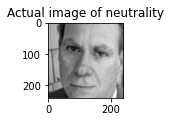

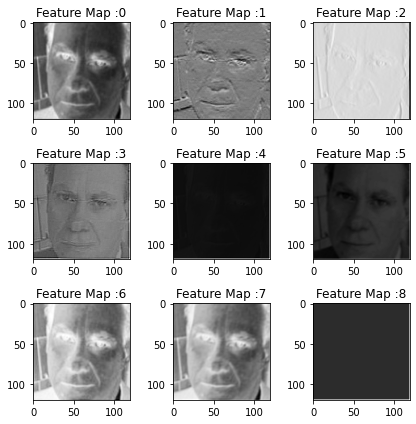

In [ ]:
#PLotting Feature Maps
fig, ax =plt.subplots(figsize=(2,2))
ax.imshow(np.squeeze(data_train_gen[ind][0][0]), cmap='gray')
ax.set_title(f'Actual image of {emotion_dict[np.argmax(data_train_gen[ind][1])]}')
fig.tight_layout()
fig, ax = plt.subplots(ncols=3, nrows=3,figsize = (6,6))
axs = ax.ravel()
activations= np.squeeze(map, axis=0)
print(activations.shape)
for i in range(9):
   axs[i].imshow(activations[:,:,i] , cmap='gray')
   axs[i].set_title(f'Feature Map :{i}')
fig.tight_layout()


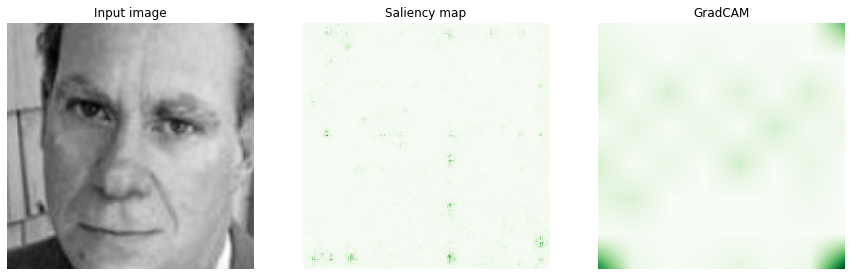

In [ ]:
# Plotting Saliency map and GradCAM
plot_saliency_cam(transfer_model, data_train_gen[ind][0][0], data_train_gen[ind][1][0]) 

# 4.Variational Autoencoders

Auto encoders are a type of Neural network structure where we divide the mode into 2 blocks. The first block is an encoder model and the second block is the decoder model. Why is this structure useful? The objective of the autoencoder model is to actually encode the input information and then use the decoder model to reconstruct the input info. The loss function is a measure that will judge how far the reconstruction output is from the input. The gradients are propagated according through both the models at once. Why do we want to reconstruct the info we already have? We hope that while we encode the information, then decode it to reconstruct it and propagate the gradients through the network to minimize the loss, we learn an encoding that has information about the input that we can use for other tasks.

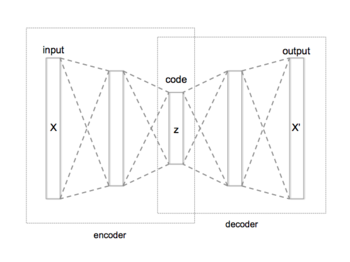

https://en.wikipedia.org/wiki/Autoencoder#:~:text=An%20autoencoder%20is%20a%20type,the%20input%20from%20the%20encoding.


The encoder typically maps the input in a lower-level latent space. Why is this useful? We can see that the information which is not linearly separable in the original dimensions might be linearly separable in some other latent space. We hope that while we are encoding the input in a lower dimensional latent space, we map the input in this space and the input is linearly seperable. This will make classification and regression tasks very easy since we don't have to learn a complex function to differentiate the points we can just learn a linear function.

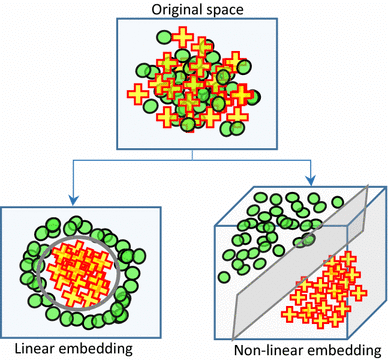

from https://www.researchgate.net/figure/Example-of-nonlinearly-separable-data-and-its-mapping-into-linearly-separable-space_fig1_320595073

In the picture above we can see that the original space is not linearly seperable and by using a non-linear kernel we can map it into a space that is linearly seperable

Once we have this latent vector from the trained autoencoder. We hope that that is has learnt high level features from the data. Now this latent vector can be used as an input to another model that asks useful questions about the data. It could be a classification task, regression task, etc. 



Autoencoders are closely related to Principal component analysis. They differ because Autoencoders us non-linear activation functions.



### 4.1.Math behind Autoencoders



Components :


X is space of decoded data


Z is the space of encoded data

Functions that map both to each other:

E : X -> Z 

E has parameters phi

D : Z -> X 

D has parameters theta 

for any x in X we can say that the latent variable is z = E_phi(x)

for any z in Z we can say that the latent variable is x = D_theta(z)

Typically both functions will be multilayer neural networks. 
The functions learned by these networks maps the X to Z and visa versa








####loss function
The loss function measures the similarity of the input and the output of the tuple of functions. 

How much x_pred differs from x. Where x was the input of the function and x_pred is the reconstruction

This couldbe measure by simply taking the mean squared error of the input and output. 

Then we would optimise that by minimising the loss function. This could be done in many ways but it's generally done using gradient descent. 

argmin L(theta, phi)

where L = 1/N sum(||x_i - D(E(x_i)||^2)

We use gradient descent to minimise this loss function. Although a diffrent loss function can be chosen but for simplicity this wass shown

**Drawbacks of vanilla autoencoders**

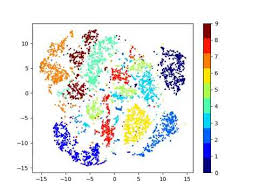

The image above shows a latent space that maps the input to this 2d dimension. 

Here we can see that there are a few problems that we will face while using this for a task 

1. The latent space has gaps in it. This means that when we want to sample from that area of the latent space we would find it difficult to understand what the data means. This is similar to not having data. For images, if there are big gaps in the latent space then we would get weird artifacts in the images sampled from between the gaps. 

2. Some points are not seperable in the space still. as we can see the light blue points are merging with the light green points. This will result in making it difficult for a model to separate these 2 classes. 

3. This latent space can't be studied as a continuous space. So our model won't be trained to take arbitrary input 

### 4.2.Variational Autoencoders

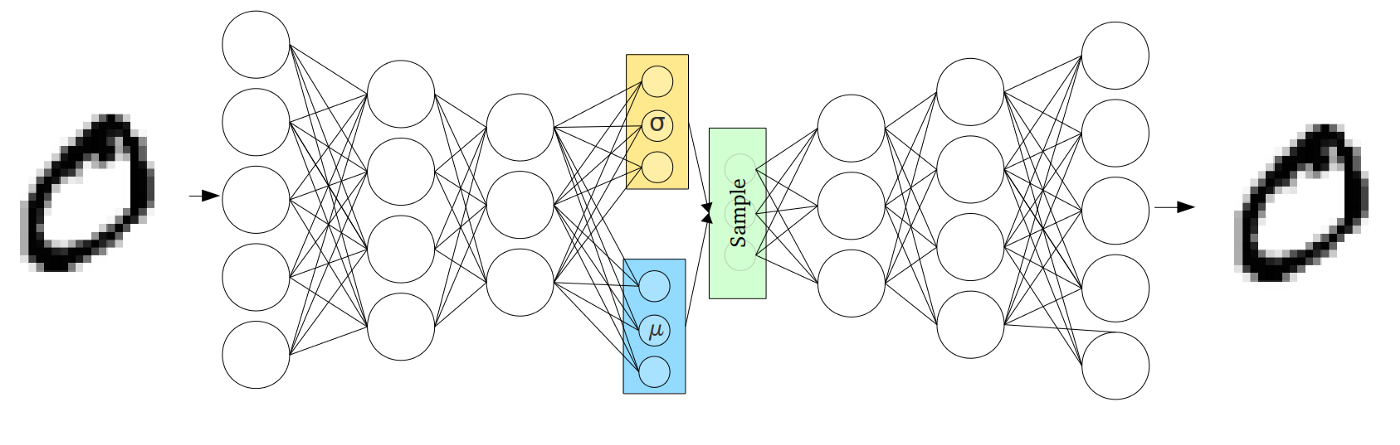

Variational autoencoders attempt to solve all of these problems with some clever tricks 

But they do something more also. They allow us to generate new,  unique, random output that has qualities of the training data. Also, you can do arithmetic and interpolation in these latent spaces. 

The latent space of variational autoencoders is continuous, by design, which is what allows us to randomly sample, interpolate and do arithmetic with it. 

We can do this since variational autoencoders have an encoder model that outputs the coordinates to the latent space like vanilla autoencoders. Here the encoder outputs 2 vectors of the size of the number of dimensions in the latent space. A vector of the means and a vector of standard deviation. It's assumed that this output will follow a gaussian distribution. 

The coordinates of this point are sampled from this distribution. So they will never be the same. 

The decoder is then fed these sampled coordinates as its input. 

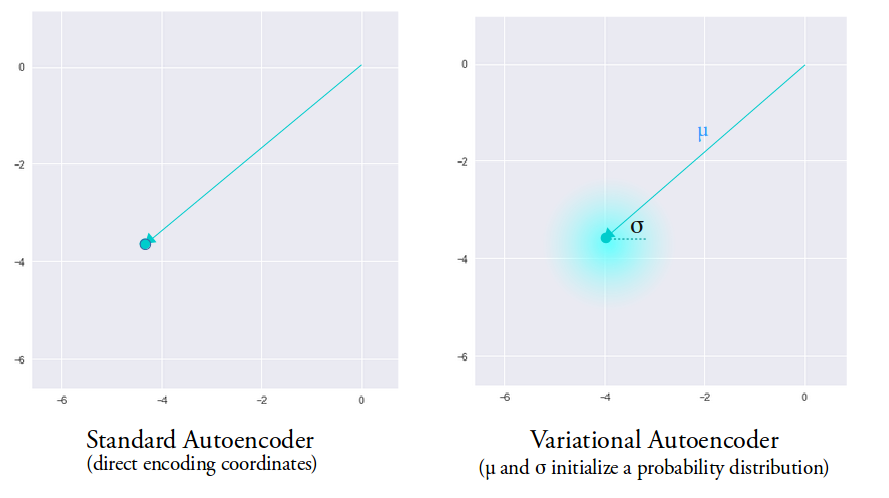

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf


In the image above, we can see that the standard autoencoder encodes the coordinates to a location in the latent space. In contrast, since the variational autoencoder encodes the mean and sd of the point rather than the point itself, we can say that every time we sample this point, the sample can be anywhere in this cloud. 

However, since the model is free to learn any mean and sd for the different classes we may experience some difficulty when the model tries to make it easy for the decoder to decode the image to get a low value in the loss. The model may achieve this by making the variance as low as possible so that there is low variance the sampled points for the decoder to decode. 

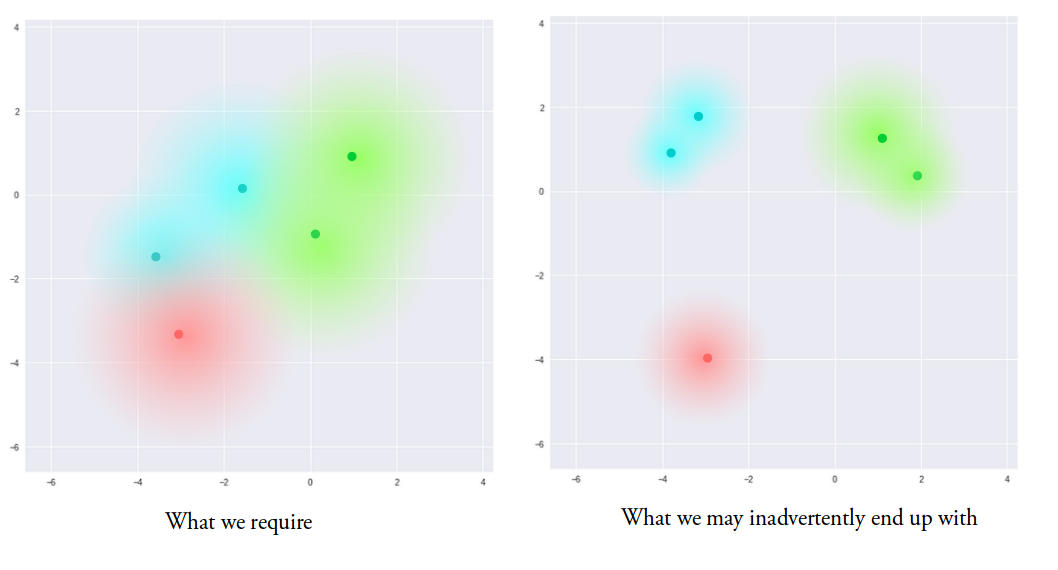

We want our encodings to not overlap but be as close as possible so that we can interpolate between them and there are no gaps when we are sampling the latent space. 


For this we use the Kullback–Leibler divergence as a part of the loss function. It's a measure of the divergence between two probability distrubutions. 

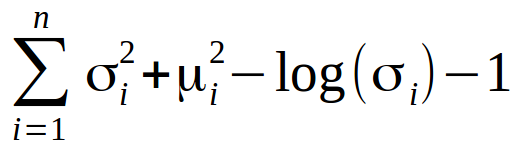

Here the kl divergence measures the divergence between the component of X and the standard normal. We can think of kl divergence as trying to make the embeddings as close to the center of the space as possible. 

But when we only have KL Divergence as the loss, we end up having all the points clustered together near the center of space. This is not useful as it will be hard to seperate one class from another. 

We can alleviate this by having a custom function which is just the two losses added together. When we try to minimise this sum of the two losses we end up solving both the problems. The points won't be too far apart and they will also not be too close together. 

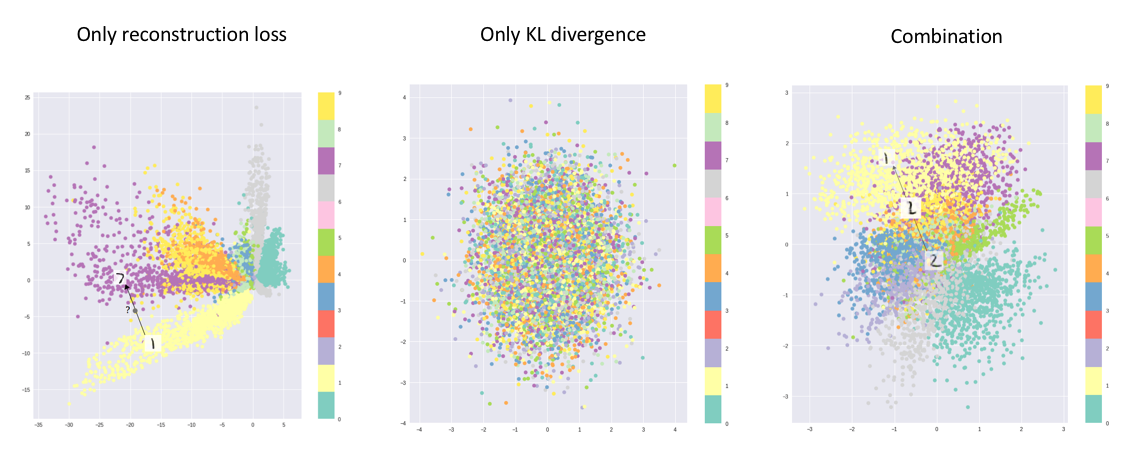

In the picture above, we can see that the latent space with only reconstruction loss has gaps in it so we won't able to interpolate to well. 

WH=hen we have only kl divergence all the point are randomly clustered near the center of teh latent space

When have the custom loss function, with both the losses we get a combination of the two effects and the latent space doesnt have gaps as well as being seperable

### 4.3.Application of variational autoencoders

Below we apply a variational autoencoder on our train dataset 1. The model has a similar architecture to what we have discussed in the theory section above. 
The architecture is similar to what has been recomended on the keras documentation website but we have a deeper convolutional neural network along with a few tweak here and there. 

### 4.4.Objectives

* What we hope to achieve with this model is that we learn mappings from the input dataset which are images to continous latent space. 

* Once we get the representation of this continous latent space, we wish to generate novel, unique examples of the input image. 

* We wish to learn a bit a more about the latent space by interpolating through the different dimentions and infering the use of some one of the dimensions. We understand that the dimension are not too simplified to infer from but interpolating will give us a look inside the latent space. 

* lastly we wish to apply some editing to the labelled images. We plan on doing this by vector arithmetic in the latent space, more will be discussed later. 





Defining a tf dataset to enable easy prefetch and parralelization 

In [ ]:
data2_train_vae = tf.keras.utils.image_dataset_from_directory(
    Dir_main+"/data/train",
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 9569 files belonging to 1 classes.


Defining AUTOTUNE to let tensorflow automatically tune the number of parrallel calls and the buffer size

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

Mapping both the datasets by calling turning images to grey scale and normalizing them between 0 and 1 

In [ ]:
# Mapping the dataset
data2_train_vae = data2_train_vae.map(map_func=tf.image.rgb_to_grayscale , num_parallel_calls=AUTOTUNE)
data2_train_vae = data2_train_vae.map(map_func= lambda x : x/255 , num_parallel_calls=AUTOTUNE)

## 4.5.Defining custom class to be used as a sampling layer



We are doing this becuase we want don't want take the derivative of a random variable since doing that will make our model unstable and make our errors large. 

We are basically sampling from this space using a random variable from the normal distrubution. 

We take this random sample and multiply the standard deviation and add the mean. Which will result in a random sample for this latent space around the mean and with standard deviation. 

This particlar function will take mean and standard deviation vectors from dense layer before and will return a sample from the result standard distrubution. 

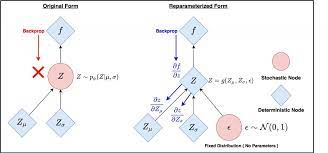

In [ ]:
class Sampling(layers.Layer):
   

    def call(self, inputs):
      ## getting the mean and standard deviation as input 
        z_mean, z_log_var = inputs
        ## getting the batch dimension 
        batch = tf.shape(z_mean)[0]
        ## getting the dimension of the latent vector
        dim = tf.shape(z_mean)[1]
        ## defining a sample epsilon from a standard normal distrubution
        e = tf.keras.backend.random_normal(shape=(batch, dim))
        #sampling for the distrubution using the formula mentioned above. 
        #This will make return a vector of shape (,dim) 
        return z_mean + tf.exp(0.5 * z_log_var) * e

## 4.6.Encoder model

Here we defined the encoder model. This will take as input the picture in the appropriate shape. 

We have several blocks of convolutional layers , Batch normalization layers and the activation layers. 

We are not using max pooling layers as we are using strides of 2 which result in the dimentiality reduction which is the objective of maxpooling layers

We flatten the put of the last convolutional block, which is fed into a Dense layer. this dense layer will be connected to Dense layers which will have outputs of shape of the latent dimention. One of these layers is supposed to return the mean and the other is supposed to return the standard deviation. 

We then have the a sampling layer which was discussed above. This will give a random sample from the normal distrubution with the mean and the standard deviation. 

We make the model and have the inputs as the picture's dimentions and the outputs as the mean variance and the sample for the resultant normal distrubution 

In [ ]:
# Defining the encoder model
latent_dim = 100 
input_shape = (256,256,1)

# Defining input layer to the encoder
encoder_inputs = tf.keras.Input(
  shape = input_shape,
  batch_size=None,
  name= 'e_input' ,
  dtype=None,
  sparse=None,
  tensor=None,
  ragged=None,
  type_spec=None)

# Convolutional layer to account for low level features using a linear activation
x = tf.keras.layers.Conv2D(
  16,
  4,
  strides=1,
  padding="same", name = 'c1')(encoder_inputs)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b1')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU(name = 'a1')(x)

# Convolutional layer using a linear activation but with stride 2 to downsample the image
x = tf.keras.layers.Conv2D(
  32,
  4,
  strides = 2,
  padding="same", name = 'c2')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b2')(x)

## using leaky relu as teh activation function
x = tf.keras.layers.ReLU (name = 'a2')(x)

# Convolutional layer using a linear activation but with stride 2 to downsample the image
x = tf.keras.layers.Conv2D(
  32,
  4,
  strides = 2,
  padding="same", name = 'c3')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b3')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU(name = 'a3')(x)

# Convolutional layer using a linear activation but with stride 2 to downsample the image
x = tf.keras.layers.Conv2D(
  64,
  4,
  strides = 2,
  padding="same", name = 'c4')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b4')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU(name = 'a4')(x)

# Convolutional layer using a linear activation but with stride 2 to downsample the image
x = tf.keras.layers.Conv2D(
  64,
  4,
  strides = 2,
  padding="same", name = 'c5')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b5')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU(name = 'a5')(x)

# Convolutional layer using a linear activation but with stride 2 to downsample the image
x = tf.keras.layers.Conv2D(
  64,
  4,
  strides = 2,
  padding="same", name = 'c6')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b6')(x)

# Using leaky relu as teh activation function
last_layer = tf.keras.layers.ReLU(name = 'a6')(x)
shape_before_flatten = tf.keras.backend.int_shape(last_layer)[1:]
flatten =Flatten()(last_layer)

x = layers.Dense(2048, activation="relu")(flatten)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Sampling()([z_mean, z_log_var])

# Building the model
encoder_model = tf.keras.models.Model(encoder_inputs, [z_mean , z_log_var , z ])

# Summarizing the model
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 e_input (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 c1 (Conv2D)                    (None, 256, 256, 16  272         ['e_input[0][0]']                
                                )                                                                 
                                                                                                  
 b1 (BatchNormalization)        (None, 256, 256, 16  64          ['c1[0][0]']                     
                                )                                                             

## 4.7.Decoder Model 

Here we define the architecture of the decoder model 

The latent dimensions are defined as 100 because that is the dimentions of the out of teh encoder models sampling layer. 

The input will be the sample from the normal distrubution with mean and stadard deviation as learned. 

Following which we basically have the opposite of the encoder model. The convolutional layers are replaced by the de convolutional layers. (conv2dTranpose)
and teh rest remains the same. 

The output of the model is of shape 256,256,1 which is the same as the input shape. 

In [ ]:
# Defining the decoder model
latent_dim = 100
shape_b4_flatten = (8, 8, 64)

# Defining input layer to the encoder
latent_input = tf.keras.Input(
  shape = (latent_dim,),
  batch_size=None,
  name= 'e_input' ,
  dtype=None,
  sparse=None,
  tensor=None,
  ragged=None,
  type_spec=None)
x = Dense(2048, activation = 'relu' , name = 'd1')(latent_input)

x = Dense(4096, name = 'd2')(x)
x = tf.keras.layers.Reshape(shape_before_flatten)(x)

# Convolutional layer to account for low level features using a linear activation
x = tf.keras.layers.Conv2DTranspose(
  64,
  4,
  strides=1,
  padding="same", name = 'c1')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b1')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU( name = 'a1')(x)

# Deconvolutional layer using a linear activation but with stride 2 to upsample the image
x = tf.keras.layers.Conv2DTranspose(
  64,
  4,
  strides = 2,
  padding="same", name = 'c2')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b2')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU( name = 'a2')(x)

# Convolutional layer using a linear activation but with stride 2 to upsample the image
x = tf.keras.layers.Conv2DTranspose(
  64,
  4,
  strides = 2,
  padding="same", name = 'c3')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b3')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU( name = 'a3')(x)

# Convolutional layer using a linear activation but with stride 2 to upsample the image
x = tf.keras.layers.Conv2DTranspose(
  32,
  4,
  strides = 2,
  padding="same", name = 'c4')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b4')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU( name = 'a4')(x)

# Convolutional layer using a linear activation but with stride 2 to upsample the image
x = tf.keras.layers.Conv2DTranspose(
  16,
  4,
  strides = 2,
  padding="same", name = 'c5')(x)

# Using batch normalization before the activation 
x = tf.keras.layers.BatchNormalization(
  axis=-1,
  momentum=0.99,
  epsilon=0.001, 
  name = 'b5')(x)

# Using leaky relu as teh activation function
x = tf.keras.layers.ReLU(name = 'a5')(x)

# Convolutional layer using a linear activation but with stride 2 to upsample the image
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, 
                padding="same", name = 'c7', activation = 'sigmoid')(x)

# Building the model
decoder = tf.keras.Model(latent_input, decoder_outputs)

# Summarizing the model
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e_input (InputLayer)        [(None, 100)]             0         
                                                                 
 d1 (Dense)                  (None, 2048)              206848    
                                                                 
 d2 (Dense)                  (None, 4096)              8392704   
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 c1 (Conv2DTranspose)        (None, 8, 8, 64)          65600     
                                                                 
 b1 (BatchNormalization)     (None, 8, 8, 64)          256       
                                                                 
 a1 (ReLU)                   (None, 8, 8, 64)          0   

### 4.8.Loss function and training loop



Here we are defining the custom training loop and the loss function. 

The exact steps are explained int the comments

In [ ]:
# Here we have used code from keras documentation examples
# Custom loss function and a custom training loop was needed since two Losses need to combined

class VAE(keras.Model):
  def __init__(self , encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    ## intializing encoder model 
    self.encoder = encoder
    ##intitializing decoder model
    self.decoder = decoder
    #initializing metrics trackers
    self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name = 'reconstruction_loss')
    self.kl_loss_tracker = keras.metrics.Mean(name = 'kl_loss')

  @property 
  def metrics(self):
    ##tracking metrics
    return[self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
  
  def train_step(self , data):
    # Defining the gradient tape
    with tf.GradientTape() as tape:

      # Getting output from encoder model into variables 
      z_mean , z_log_var , z = self.encoder(data)
      # Getting the reconstruction from the decoder model 
      recon = self.decoder(z)
      # Using binary crossentropy as the reconstruction loss
      recon_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, recon), axis=(1, 2)))

      # Defining the kl divergence loss 
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

      # Defining the total loss
      total_loss = recon_loss + kl_loss
    
    ## asking the gradient tape to record gradients of the loss that we defined
    ## with respect to the weights of the whole model. 
    ## Note: The parameters of both the models are trained simultaneously 
    gradients = tape.gradient(total_loss , self.trainable_weights)

    
    ## Taking one step in the negative direction of the derivative. 
    ## Here we are just applying the gradients according to the optimiser 
    ## that we will define when we compile the model
    self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
    
    ## Updating the loss as calculated
    self.reconstruction_loss_tracker.update_state (recon_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    self.total_loss_tracker.update_state(total_loss)

    return{
        ## returning  a dict with loss after the train step
        "loss" : self.total_loss_tracker.result(), 
        "reconstruction_loss" : self.reconstruction_loss_tracker.result(), 
        "kl_loss" : self.kl_loss_tracker.result()
    }

In [ ]:
# Prefetching dataset to train faster
data2_train_vae.prefetch(buffer_size=AUTOTUNE)

<PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)>

Training for 100 epochs , batch size 16 and the prefetch as per the AUTOTUNE parameter

In [ ]:
if os.path.isfile("model_encwts2.h5") and os.path.isfile("model_decwts2.h5"):
  # Loading weights if they are present
  encoder_model.load_weights('model_encwts2.h5')
  decoder.load_weights('model_decwts2.h5')

  # Compiling the variational encoder
  var_auto_encoder = VAE(encoder_model, decoder)
  var_auto_encoder.compile(optimizer = 'adam')

else:
  # Compile the model when the weights are not there are then train
  var_auto_encoder = VAE(encoder_model, decoder)
  var_auto_encoder.compile(optimizer = 'adam')

  # Training the model
  history = var_auto_encoder.fit(data2_train_vae.prefetch(buffer_size=AUTOTUNE), epochs=100, batch_size = 16)

  # Saving and downloading weights
  var_auto_encoder.save_weights("modelwts2.h5")
  var_auto_encoder.encoder.save_weights("model_encwts2.h5")
  var_auto_encoder.encoder.save("model_enc2.h5")
  var_auto_encoder.decoder.save_weights("model_decwts2.h5")
  var_auto_encoder.decoder.save("model_dec2.h5")
  var_auto_encoder.save_weights("model_varwts2.h5")
  files.download("model_encwts2.h5")
  files.download("model_enc2.h5")
  files.download("model_decwts2.h5")
  files.download("model_dec2.h5")

This is what the encoder and decoder models look like respectively

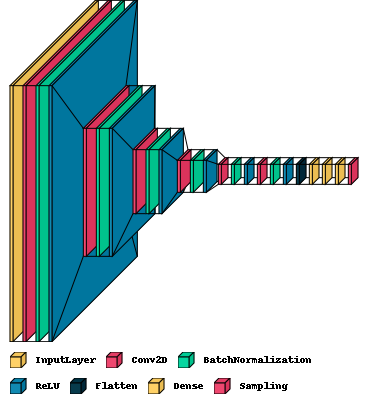

In [ ]:
visualkeras.layered_view((encoder_model), legend = True, scale_xy=1, scale_z=1, max_z=3)

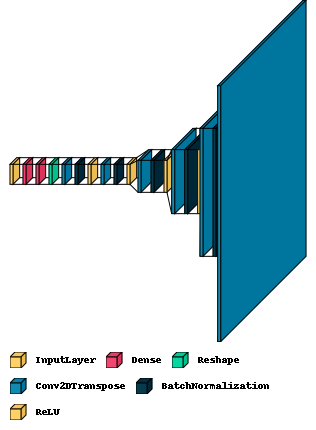

In [ ]:
visualkeras.layered_view(decoder, legend = True, scale_xy=1, scale_z=1, max_z=3)

### 4.9.Sampling from the latent space

Here we are taking a batch of 32 images and feeding it to the encoder. 
This will return a list of the mean , log variance and a sample from the space also. We can either directly use the z or we can sample from the resultant distrubution

In [ ]:
reconstruct_encode = var_auto_encoder.encoder.predict(data2_train_vae.take(1))

Defining the sampler as a fucntion to use on these images 

In [ ]:
def sample_from_z(encoding):
        z_mean, z_log_var, z = encoding
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
z = sample_from_z(reconstruct_encode)

# Changing the latent space into an array
z_arr= np.array(z)

# Decoding the resultant latent vectors
decode =  var_auto_encoder.decoder.predict(z_arr)

Showing the generated image from the input 

In this case it was the 14rth image of the list

In [ ]:
image_list = []
for i in data2_train_vae.take(1):
  image_list.append(i)

In [ ]:
image_list = image_list[0]

# Predicting using the encoder and decoding it.
_, _, encode1 = var_auto_encoder.encoder.predict(np.expand_dims(image_list[14], axis =0))
decode1 =  var_auto_encoder.decoder.predict(encode1)

In [ ]:
# Plotting the images
fig , ax = plt.subplots(1, 2 , figsize = (10,10))
ax[0].imshow(np.array(image_list[14,  : , :, 0]), cmap = 'gray')
ax[0].set_title(f'Input', fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(decode1[0, : , :, 0], cmap = 'gray')
ax[1].set_title(f'Sample from Z decoded', fontsize = 10)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
fig.suptitle(f'Image recreation', y=.8)


We can see that input of the encoder and the subsequent output of the decoder. The output of the model is , as expected, slightly different from teh original image. The model well creating a unique image but at the same time keeping the expressions of the original image. 

Admittedly, the output of the model is not as higg quality as the input and the output losses some defination. It just seems a bit blurry. Probably training for longer will solve this as reconstruction loss will go down with more training. 

### 4.10.Interpolation in the latent space

Now we will attempt to traverse the latent space in which reside our encodings from our encoder model. 

We will do this by changing the values of the encoding for a picture that has already been decoded and see how traversing that dimension changes the output image once the decoder decodes it. 

What we hope to find is a few dimentions that are explainable. For example if the values in the 39th dimension is changed by a factor 2 then the resultant picture changes from a original happy picture to a sad one or visa versa. 


In [ ]:
## Chaning the latent vector into an array
z_arr= np.array(z)

## Defining a list using which we will change the values in the selected dimension
delta_list = [-10,-8,-4,-2, 0 ,2,4,8,10]
## looping over all dimensions
for i in range(100):
  ##Defining az delt list
  z_delta_list = []
  
  ## defining the figure and subplots for plotting
  f, axarr = plt.subplots(1,9, figsize = (15,15))
  ## defining the title for each figue in the output
  f.suptitle(f'interpolation for dimension {i} ', y=0.58)
  
  ## looping over all the delta values in the the list
  for j in range(len(delta_list)):
    z_arr= np.array(z)
    z_arr1 = z_arr 
    ##Calculatin gthe value of the selected dimension
    new_ith_dim = z_arr1[: , i] * delta_list[j] * 2
    
    ##assigning the new value of the selected dimnesion
    z_arr1[: , i] = new_ith_dim 
    
    ## Decoding the changed latent vector to see the resultant changes in output 
    decode =  var_auto_encoder.decoder.predict(z_arr1)
    
    ##plotting
    axarr[j].imshow(decode[7, : , :, 0], cmap = 'gray')
    axarr[j].set_title(f'original  * {delta_list[j]* 2 }', fontsize = 10)
    axarr[j].get_xaxis().set_visible(False)
    axarr[j].get_yaxis().set_visible(False)
  
  f.tight_layout(rect=[0, 0.03, 1, 0.95])

In the output we can see that we traversed through each and every dimension in the latent space using the list. 

The values in the latent space were changed by different numbers so that we can see the affect of the dimension on the output image. 

When we inspect the images in the output, we can see that for each dimension some characteristics of the output image change. 

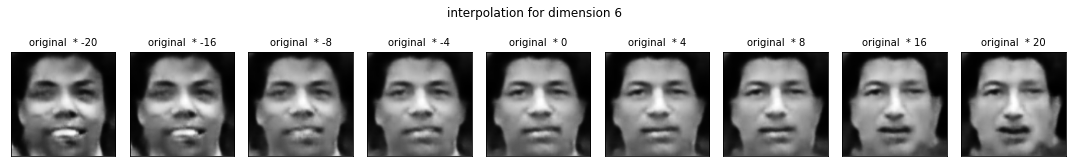

For example, in the above picture, when multiply the latent vector by a negative number we start going towards a smilling face from a face that originally a neutral face. If we multiply by a postive number we see the image going towards a surprised expression.

Notice that the original picture didn't have teeth in it but when we start going in teh negative direction in dimension 6 we start seeing a smile with teeth.

Now we can finetune the delta values to get the image we want. If we want a smile with no teeth we just multiply the latent vector by -4 and we will get the desired result. 

This is not the only experiment we did. Below are a few interesting dimensions in the latent space for different images generated by the model. 

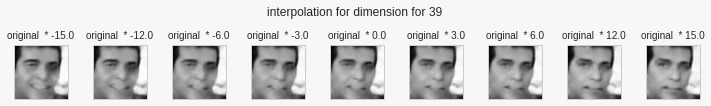

Here the man in the picture starts smiling and frowning as we traverse through dimention 39. 

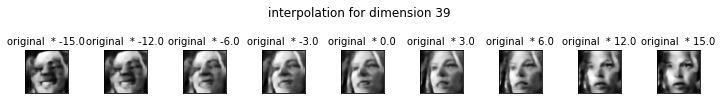

Here we see the same thing, the smiling woman smiles more as we traverse in teh negative direction and becomes neutral in the positive direction. 

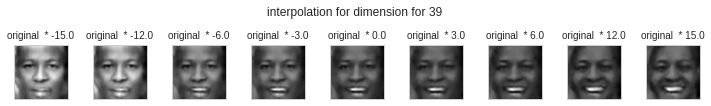

Here the man is smiling with the teeth visible, but as we go in the negative direction his teeth are not visible. 

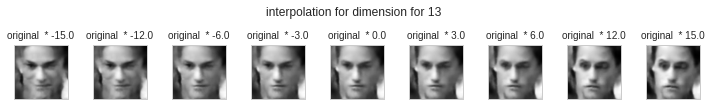

Similar thing for this image

So this gives us an insight inside the latent space and how it affects the output of the decoder model. 

However, it's important to understand that the features that we are looking for are most likely decided by values in a combination of dimensions and not just one. So interpolating this way may not be the most useful thing to do, although it gives us an insight on what is going on inside the latent space. 

In the next section we come up with a better way to traverse through thos latent space. 


## 4.11.Expression editing using vector arithmetic in the latent space

Here we will attempt to edit the expression of an image using the variational autoencoder that we have trained. 

 


Below we can see that we can add and subtract latent vectors and come up with useful generated examples. Each image in this example can be thought of as a latent vector decoded.

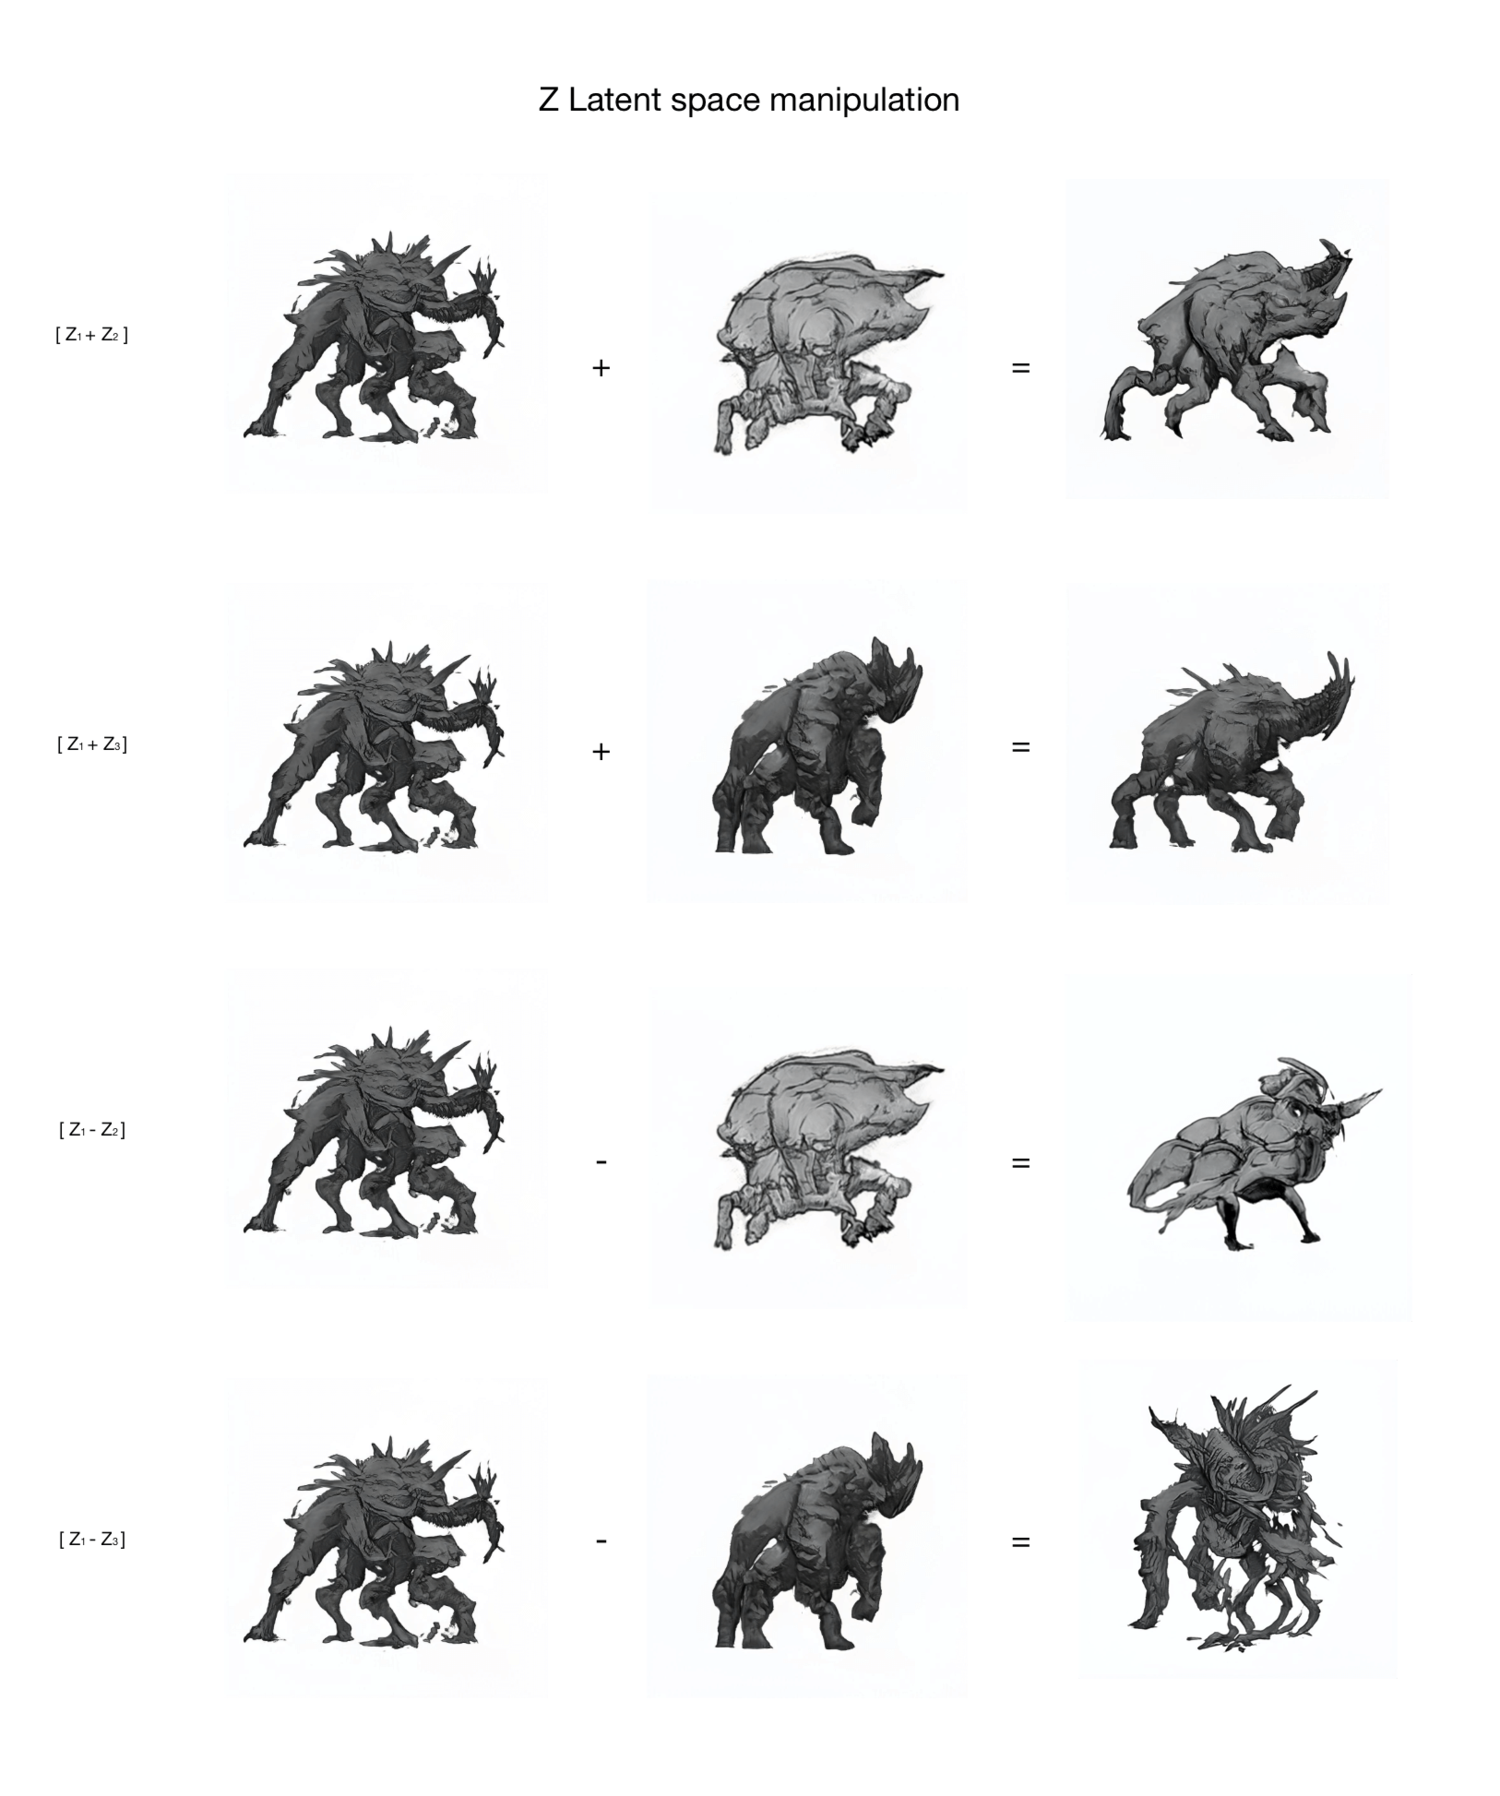

The concept is best explained by an example. 

Suppose we start with a image of a woman with a happy expression and we wish to copy the same expression onto a mans face. We can do this by using arithmetic in the latent space that we have learned through out variational autoencoder. 

We first take the image of the woman with a happy expression. Feed it to our encoder model which will map it to the latent space using a latent vector defined by the mean and variance. 

Now we do this for a woman which has a neutral expression (preferably the same woman) and repeat the process. We feed it to the encoder and get the latent vector. 

Now take the image of a man who has a neutral expression. Feed it to the encoder and get the latent vector. 

Now that we have the latent vectors we can simply subtract the latent vector of the neutral woman from the smiling woman. In theory this should give us the vector that determines the smile in the latent space. We can add this vector to the vector of the of the neutral man and then decode the resultant vector to generate an image of a smiling man 

This way we can come up with different vectors for different operations. 

In this experiment, we take an average over many vectors for better accuracy.

### 4.11.1.Vector arithmetic with a single picture

We will take pictures of face pertaining to specific emotions. We will then encode these pictures and take a sample from the latent space to see the reconstruction. Once we have that we can use the resultant latent vector to do some arithmetic. If we subtract the latent vector of a neutral woman from a surprised woman then we should get a vector pertaining to being surprised. 

We can then add this vector to a neutral man vector to change the latent vector from being that of a neutral man to a surpised man. Once we do this we can decode this vector to generate an image of a surprised man. 

This is exactly what we are doing below 


In [ ]:
from PIL import Image
surprised_woman = np.asarray(Image.open(r"/content/drive/MyDrive/Preprocessing/data2/train/surprise/Winona_Ryder_0012.jpg"))
neutral_woman = np.asarray(Image.open(r'/content/drive/MyDrive/Preprocessing/data2/train/neutrality/Angelina_Jolie_0007.jpg'))
neutral_man = np.asarray(Image.open(r'/content/drive/MyDrive/Preprocessing/data2/train/neutrality/Alastair_Campbell_0001.jpg'))

In [ ]:
surprised_woman= tf.image.resize(
    np.expand_dims(surprised_woman, axis = -1),
    [256,256])
surprised_woman = surprised_woman/255

surprised_woman_encode = var_auto_encoder.encoder.predict(np.expand_dims(surprised_woman, axis = 0))
surprised_woman_sample_vector = sample_from_z(surprised_woman_encode)
surprised_woman_decoded = var_auto_encoder.decoder.predict(surprised_woman_sample_vector)

In [ ]:
fig , ax = plt.subplots(1, 2 , figsize = (10,10))
ax[0].imshow(surprised_woman[ :, :, 0]/255, cmap = 'gray')
ax[0].set_title(f'Actual', fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(surprised_woman_decoded[0, :, :, 0]/255, cmap = 'gray')
ax[1].set_title(f'Sample from Z decoded', fontsize = 10)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
fig.suptitle(f'Image recreation - surprised woman', y=.8)


In [ ]:
neutral_woman= tf.image.resize(
    np.expand_dims(neutral_woman, axis = -1),
    [256,256])
neutral_woman = neutral_woman/255
neutral_woman_encode = var_auto_encoder.encoder.predict(np.expand_dims(neutral_woman, axis = 0))
neutral_woman_sample_vector = sample_from_z(neutral_woman_encode)
neutral_woman_decoded = var_auto_encoder.decoder.predict(neutral_woman_sample_vector)

In [ ]:
# Plotting the sample decoded images 
fig , ax = plt.subplots(1, 2 , figsize = (10,10))
ax[0].imshow(neutral_woman[:, :, 0]/255, cmap = 'gray')
ax[0].set_title(f'Actual', fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(neutral_woman_decoded[0, :, :, 0]/255, cmap = 'gray')
ax[1].set_title(f'Sample from Z decoded', fontsize = 10)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
fig.suptitle(f'Image recreation - neutral woman', y=.8)

In [ ]:
neutral_man= tf.image.resize(
    np.expand_dims(neutral_man, axis = -1),
    [256,256])
neutral_man = neutral_man/255
neutral_man_encode = var_auto_encoder.encoder.predict(np.expand_dims(neutral_man, axis = 0))
neutral_man_sample_vector = sample_from_z(neutral_man_encode)
neutral_man_decoded = var_auto_encoder.decoder.predict(neutral_man_sample_vector)

In [ ]:
# Plotting the actual and decoded images
fig , ax = plt.subplots(1, 2 , figsize = (10,10))
ax[0].imshow(neutral_man[:, :, 0]/255, cmap = 'gray')
ax[0].set_title(f'Actual', fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(neutral_man_decoded[0, :, :, 0]/255, cmap = 'gray')
ax[1].set_title(f'Sample from Z decoded', fontsize = 10)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
fig.suptitle(f'Image recreation - neutral man', y=.8)

In [ ]:
surprised_man_sample_vector1 = neutral_man_sample_vector + 1 * (surprised_woman_sample_vector - neutral_woman_sample_vector)
surprised_man_decoded1 =  var_auto_encoder.decoder.predict(surprised_man_sample_vector1)

In [ ]:
# Plotting the actual and decoded images
f, ax = plt.subplots(1, 4, figsize = (20,20))
ax[0].imshow(surprised_woman_decoded[0, :, :, 0], cmap = 'gray')
ax[0].set_title('Surprised woman')

ax[1].imshow(neutral_woman_decoded[0, :, :, 0], cmap = 'gray')
ax[1].set_title('neutral woman')
ax[2].imshow(neutral_man_decoded[0, :, :, 0], cmap = 'gray')
ax[2].set_title('neutral man')
ax[3].imshow(surprised_man_decoded1[0, :, :, 0], cmap = 'gray')
ax[3].set_title(' Surprised man')
f.suptitle(f'Surprised woman   -   neutral woman   +   neutral man   =   surprised man', y=.65)


### 4.12.Vector arithmetic using the mean of multiple vectors

#### 4.12.1.Calulating the average latent vector for the happy faces in the data

Here we take many pictures from the data and encode each one of them. Then we take the mean of the vectors for each value in the sample from the gaussian distrubution. So we arrive at the average vector for happy faces. 
This will help us generalize the arithmetic to many pictures  

In [ ]:
data_happy_images = tf.keras.utils.image_dataset_from_directory(
    Dir_main+"/data2/train/happiness",
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size= 512,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

data_happy_images = data_happy_images.map(map_func=tf.image.rgb_to_grayscale , num_parallel_calls=AUTOTUNE)


data_happy_images = data_happy_images.map(map_func= lambda x : x/255 , num_parallel_calls=AUTOTUNE)

Found 3982 files belonging to 1 classes.


In [ ]:
happy_batch = data_happy_images.take(1)
_, _, happy_batch_encoded = var_auto_encoder.encoder.predict(happy_batch)

# Getting the mean vector
happy_batch_mean_vector = np.sum(happy_batch_encoded, axis = 0)/happy_batch_encoded.shape[0]

In [ ]:
happy_batch_mean_decode =  var_auto_encoder.decoder.predict(np.expand_dims(happy_batch_mean_vector, axis = 0))

In [ ]:
# Plotting the mean vector
fig , ax = plt.subplots(1,1 , figsize = (10,10))
ax.imshow(happy_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax.set_title(f'Mean happy face', fontsize = 10)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.suptitle(f'Decoded mean vector for happy faces', y=1)

### We repeat this process for angry faces, sad faces, surprised faces and neutral faces

#### 4.12.2.Anger mean latent vector

In [ ]:
data_anger_images = tf.keras.utils.image_dataset_from_directory(
    Dir_main+"/data2/train/anger",
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size= 512,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

data_anger_images = data_anger_images.map(map_func=tf.image.rgb_to_grayscale , num_parallel_calls=AUTOTUNE)


data_anger_images = data_anger_images.map(map_func= lambda x : x/255 , num_parallel_calls=AUTOTUNE)

Found 176 files belonging to 1 classes.


In [ ]:
anger_batch = data_anger_images.take(1)
_, _, anger_batch_encoded = var_auto_encoder.encoder.predict(anger_batch)

# Getting the mean vector
anger_batch_mean_vector = np.sum(anger_batch_encoded, axis = 0)/anger_batch_encoded.shape[0]

In [ ]:
anger_batch_mean_decode =  var_auto_encoder.decoder.predict(np.expand_dims(anger_batch_mean_vector, axis = 0))

In [ ]:
# Plotting the mean vector
fig , ax = plt.subplots(1,1 , figsize = (10,10))
ax.imshow(anger_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax.set_title(f'Mean angry face', fontsize = 10)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.suptitle(f'Decoded mean vector for angry faces', y=1)

#### 4.12.3.Sadness mean latent vector

In [ ]:
data_sad_images = tf.keras.utils.image_dataset_from_directory(
    Dir_main+"/data1/train/sadness",
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size= 512,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

data_sad_images = data_sad_images.map(map_func=tf.image.rgb_to_grayscale , num_parallel_calls=AUTOTUNE)


data_sad_images = data_sad_images.map(map_func= lambda x : x/255 , num_parallel_calls=AUTOTUNE)

Found 3782 files belonging to 1 classes.


In [ ]:
sad_batch = data_sad_images.take(1)
_, _, sad_batch_encoded = var_auto_encoder.encoder.predict(sad_batch)

# Getting the mean vector
sad_batch_mean_vector = np.sum(sad_batch_encoded, axis = 0)/sad_batch_encoded.shape[0]

In [ ]:
sad_batch_mean_decode =  var_auto_encoder.decoder.predict(np.expand_dims(sad_batch_mean_vector, axis = 0))

In [ ]:
fig , ax = plt.subplots(1,1 , figsize = (10,10))
ax.imshow(sad_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax.set_title(f'Mean sad face', fontsize = 10)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.suptitle(f'Decoded mean vector for sad faces', y=1)

#### 4.12.4.Surprise mean latent vector

In [ ]:
data_surprise_images = tf.keras.utils.image_dataset_from_directory(
    Dir_main+"/data2/train/surprise",
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size= 250,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

data_surprise_images = data_surprise_images.map(map_func=tf.image.rgb_to_grayscale , num_parallel_calls=AUTOTUNE)


data_surprise_images = data_surprise_images.map(map_func= lambda x : x/255 , num_parallel_calls=AUTOTUNE)

Found 257 files belonging to 1 classes.


In [ ]:
surprise_batch = data_surprise_images.take(1)
_, _, surprise_batch_encoded = var_auto_encoder.encoder.predict(surprise_batch)

# Getting the mean vector
surprise_batch_mean_vector = np.sum(surprise_batch_encoded, axis = 0)/surprise_batch_encoded.shape[0]

In [ ]:
surprise_batch_mean_decode =  var_auto_encoder.decoder.predict(np.expand_dims(surprise_batch_mean_vector, axis = 0))

In [ ]:
# Plotting the mean vector
fig , ax = plt.subplots(1,1 , figsize = (10,10))
ax.imshow(surprise_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax.set_title(f'Mean surprised face', fontsize = 10)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.suptitle(f'Decoded mean vector for surprised faces', y=1)

#### 4.12.5.Neutral mean latent vector


In [ ]:
data_neutral_images = tf.keras.utils.image_dataset_from_directory(
    Dir_main+"/data2/train/neutrality",
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size= 512,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

data_neutral_images = data_neutral_images.map(map_func=tf.image.rgb_to_grayscale , num_parallel_calls=AUTOTUNE)


data_neutral_images = data_neutral_images.map(map_func= lambda x : x/255 , num_parallel_calls=AUTOTUNE)

Found 4802 files belonging to 1 classes.


In [ ]:
neutral_batch = data_neutral_images.take(1)
_, _, neutral_batch_encoded = var_auto_encoder.encoder.predict(neutral_batch)

# Getting the mean vector
neutral_batch_mean_vector = np.sum(neutral_batch_encoded, axis = 0)/neutral_batch_encoded.shape[0]

In [ ]:
neutral_batch_mean_decode =  var_auto_encoder.decoder.predict(np.expand_dims(neutral_batch_mean_vector, axis = 0))

In [ ]:
# Plotting the mean vector
fig , ax = plt.subplots(1,1 , figsize = (10,10))
ax.imshow(neutral_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax.set_title(f'Mean neutral face', fontsize = 10)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.suptitle(f'Decoded mean vector for neutral faces', y=1)

## 4.13.Resultant mean latent vectors 

In [ ]:
fig , ax = plt.subplots(1,4, figsize = (15,15))
ax[0].imshow(neutral_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax[0].set_title(f'Mean happy face', fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(happy_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax[1].set_title(f'Mean happy face', fontsize = 10)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[2].imshow(anger_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax[2].set_title(f'Mean angry face', fontsize = 10)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

ax[3].imshow(surprise_batch_mean_decode[0,:, :, 0], cmap = 'gray')
ax[3].set_title(f'Mean surprised face', fontsize = 10)
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

fig.suptitle(f'Decoded mean vector for happy faces', y=0.65)

We can that these face look like they have the expression that they are encoded with when decoded using the decoder. 

### 4.14.Calculating emotion vectors 

To make the emotion edits we need the diffrence between the mean vectors of teh emotions and the neutral mean vector. That way we can calculate the vectors for the emotions. 

We can use these latent vectors to edit the original picture emotions by adding or subtracting the emotion vector.  

In [ ]:
## taking the difference between the mean emotion vectors and the neutral mean vector
## by doig this we arrive arrive at the emotion vectors
happy_vector = happy_batch_mean_vector - neutral_batch_mean_vector
anger_vector = anger_batch_mean_vector - neutral_batch_mean_vector
surprise_vector = surprise_batch_mean_vector - neutral_batch_mean_vector
sad_vector = sad_batch_mean_vector - neutral_batch_mean_vector

In [ ]:
happy_vector_decoded =  var_auto_encoder.decoder.predict(np.expand_dims(happy_vector, axis = 0))
anger_vector_decoded =  var_auto_encoder.decoder.predict(np.expand_dims(anger_vector, axis = 0))
surprise_vector_decoded =  var_auto_encoder.decoder.predict(np.expand_dims(surprise_vector, axis = 0))
sad_vector_decoded =  var_auto_encoder.decoder.predict(np.expand_dims(sad_vector, axis = 0))

In [ ]:
fig , ax = plt.subplots(1,4, figsize = (15,15))
ax[0].imshow(happy_vector_decoded[0,:, :, 0], cmap = 'gray')
ax[0].set_title(f'happy vector', fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(anger_vector_decoded[0,:, :, 0], cmap = 'gray')
ax[1].set_title(f'angry vector', fontsize = 10)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[2].imshow(surprise_vector_decoded[0,:, :, 0], cmap = 'gray')
ax[2].set_title(f'surprised vector', fontsize = 10)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

ax[3].imshow(sad_vector_decoded[0,:, :, 0], cmap = 'gray')
ax[3].set_title(f'sad vector', fontsize = 10)
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

fig.suptitle(f'emotion vectors', y=0.65)

Here we visualised what the emotion vectors look like 

Now we edit the latent vector of the original image but adding the emotion vectors times 2. 

## 4.15.Expression editing

In [ ]:
happy_man_decoded =  var_auto_encoder.decoder.predict(neutral_man_sample_vector + (2* happy_vector))
sad_man_decoded =  var_auto_encoder.decoder.predict(neutral_man_sample_vector + (2 * sad_vector))
surprise_man_decoded =  var_auto_encoder.decoder.predict(neutral_man_sample_vector + (2 * surprise_vector))
anger_man_decoded =  var_auto_encoder.decoder.predict(neutral_man_sample_vector + (2 * anger_vector))

In [ ]:
f, ax = plt.subplots(1, 4, figsize = (20,20))
ax[0].imshow(neutral_man_decoded[0, :, :, 0], cmap = 'gray')
ax[0].set_title('Neutral')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(happy_man_decoded[0, :, :, 0], cmap = 'gray')
ax[1].set_title('happy')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[2].imshow(surprise_man_decoded[0, :, :, 0], cmap = 'gray')
ax[2].set_title('surprised')
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

ax[3].imshow(anger_man_decoded[0, :, :, 0], cmap = 'gray')
ax[3].set_title('angry')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)


f.suptitle(f'Emotion editing for using latent variables', y=0.65)

Viola!! here we took an imae of neutral man, and edited the expression on his face using the emotion vectors we calcualted earlier. 

The happy face look pretty good. So does the angry face. 

When we are using the surprise vector we are not able to recreate the mouth properly although it looks vaguely like a surprised man. 

Now we will make a list of different pictures, generate an image through the variational autoencoder and then edit the emotion through latent vector arithmetic in the latent vector space

In [ ]:
## Pictures to edit
pic1 = np.asarray(Image.open(r'/content/drive/MyDrive/Preprocessing/data2/train/neutrality/Arminio_Fraga_0006.jpg'))
pic2 = np.asarray(Image.open(r'/content/drive/MyDrive/Preprocessing/data2/train/neutrality/Adisai_Bodharamik_0001.jpg'))
pic3 = np.asarray(Image.open(r'/content/drive/MyDrive/Preprocessing/data2/train/neutrality/Ahmed_Chalabi_0001.jpg'))
pic4 = np.asarray(Image.open(r'/content/drive/MyDrive/Preprocessing/data2/train/neutrality/Ainsworth_Dyer_0001.jpg'))
pic5 = np.asarray(Image.open(r'/content/drive/MyDrive/Preprocessing/data2/train/neutrality/Bill_Clinton_0003.jpg'))

pic_list = [pic1, pic2, pic3, pic4, pic5]

pic_list = list(map(lambda x : tf.image.resize(np.expand_dims(x, axis = -1),[256,256]), pic_list))
pic_list = list(map(lambda x : x/255, pic_list))

In [ ]:
np.array(len(pic_list))

array(5)

In [ ]:
happy_vector = happy_batch_mean_vector - neutral_batch_mean_vector
anger_vector = anger_batch_mean_vector - neutral_batch_mean_vector
surprise_vector = surprise_batch_mean_vector - neutral_batch_mean_vector
sad_vector = sad_batch_mean_vector - neutral_batch_mean_vector

emotion_vector_list = [1/2 , happy_vector, anger_vector, surprise_vector]
emotion_vector_name_list = ['Neutral', 'Happy', 'Angry', 'surprise']

In [ ]:
for i in range(len(pic_list)):
  ##Defining az delt list
  
  pic_encode = var_auto_encoder.encoder.predict(np.expand_dims(pic_list[i], axis = 0))
  pic_sample_vector = sample_from_z(pic_encode)
  
  
  ## defining the figure and subplots for plotting
  f, axarr = plt.subplots(1,4, figsize = (15,15))
  ## defining the title for each figue in the output
  f.suptitle(f'Emotion editing for image {i}', y=0.70)

  for j in range(len(emotion_vector_list)):
    
    pic_decoded = var_auto_encoder.decoder.predict(pic_sample_vector + (2*emotion_vector_list[j]))

    axarr[j].imshow(pic_decoded[0, : , :, 0], cmap = 'gray')
    axarr[j].set_title(f'{emotion_vector_name_list[j]}', fontsize = 10)
    axarr[j].get_xaxis().set_visible(False)
    axarr[j].get_yaxis().set_visible(False)

  f.tight_layout(rect=[0, 0.03, 1, 0.95])

We took pictures generated by the autoencoders using actual pictures and did the same editing we did earlier. Seems like this generalizes pretty well. Although the orientation of the pictures really matters in the quality of the reconstruction. 

## 4.16.Animation

In [ ]:
# Defining the image target size and number of frames for animation
TARGET_SIZE = (256,256)
NUM_FRAMES = 250

# Artist which draws each frame
def blend_image(k, image1, image2):
    c = k/NUM_FRAMES
    blended_image = (1-c)*image1 + c*image2
    return blended_image

# Function which animates and sends the output of artist
def animate_blending(k, art, image1, image2):
    blended_image = blend_image(k, image1, image2)
    art.set_array(blended_image)
    return art,

In [ ]:
# Creating a figure and axis for animation
ani_fig, ani_ax = plt.subplots(1,1)

# Setting axes properties
ani_ax.axis('off')
ani_ax.set_title("Neutral man to happy man")
art = ani_ax.imshow(np.zeros(TARGET_SIZE), cmap='gray', vmin=0, vmax=1)

# Creating the animation
my_animation = FuncAnimation(ani_fig, animate_blending, frames=NUM_FRAMES, fargs = (art, (neutral_man_decoded[0, :, :, 0]), (happy_man_decoded[0, :, :, 0])), blit=True)

In [ ]:
# Viewing the animation
HTML(my_animation.to_jshtml())

In [ ]:
# Creating a figure and axis for animation
ani_fig, ani_ax = plt.subplots(1,1)

# Setting the axes properties
ani_ax.axis('off')
ani_ax.set_title("Neutral man to surprised man")
art = ani_ax.imshow(np.zeros(TARGET_SIZE), cmap='gray', vmin=0, vmax=1)

# Creating the animation
my_animation2 = FuncAnimation(ani_fig, animate_blending, frames=NUM_FRAMES, fargs = (art, (neutral_man_decoded[0, :, :, 0]), (surprise_man_decoded[0, :, :, 0])), blit=True)

In [ ]:
# Viewing the animation
HTML(my_animation2.to_jshtml())

In [ ]:
## Saving the animations. Uncomment the following lines of code if you want to save them.
# writergif = animation.PillowWriter(fps=30) 
# my_animation.save("neutral_to_happy.gif", writer=writergif)
# my_animation2.save("neutral_to_surprised.gif", writer=writergif)

# Conclusion
The custom model and the transfer learning performed very well. The better performance of custom model indicates that this task requires a localized model over a generalized model. The transfer learning model, however, might perform better on a more diverse dataset.

Variational autoencoders captured the features of the images in the latent space, and these features could be combined to create new images of same person with different expressions. Interpolation along different dimensions in the latent space gave rise to different effects on an image. This reveals that different dimensions effectively captured different parts of a face and it's variations. Animations of transitions potray this process step-by-step.

In general, we believe the dataset was not expressive enough in terms of the orientation of the face and the proximity of the face. Reliable datasets were not easily available, with most online datasets having incorrect labels. This has limited our models' performance. The true potential of variational autoencoders could be realized with a more voluminous dataset.

##References



1. https://gist.github.com/tushuhei/380f75c2e0db35b24a48f7dd7b898bb1

2. https://blog.keras.io/building-autoencoders-in-keras.html

3. https://console.paperspace.com/ml-showcase/notebook/r0uxmfm6hvw0duf?file=%2FVAE.ipynb


4. https://github.com/developershutt/Autoencoders/blob/main/4%20-%20Variational%20Autoencoder/Variational%20Autoencoder.ipynb

5. https://keras.io/examples/generative/vae/

6. https://gist.github.com/tushuhei/380f75c2e0db35b24a48f7dd7b898bb1

7. https://stackoverflow.com/questions/3823752/display-image-as-grayscale-using-matplotlib

8. https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html
https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

9. https://www.codegrepper.com/code-examples/python/matplotlib+space+between+subplots+and+main+title

10. https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipy


11. https://blog.keras.io/building-autoencoders-in-keras.html

12. https://stackoverflow.com/questions/69038669/valueerror-input-0-of-layer-conv1d-is-incompatible-with-the-layer-expected-m

13. https://stackoverflow.com/questions/49634488/keras-variational-autoencoder-nan-loss

14. https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

15. https://stats.stackexchange.com/questions/304289/variational-autoencoder-understanding-the-latent-loss

16. https://www.geeksforgeeks.org/save-and-load-models-in-tensorflow/#:~:text=Using%20save_weights()%20method&text=It%20saves%20the%20weights%20of,saved%20using%20save_weights()%20method.

17. https://www.geeksforgeeks.org/save-and-load-models-in-tensorflow/#:~:text=Using%20save_weights()%20method&text=It%20saves%20the%20weights%20of,saved%20using%20save_weights()%20method.

18. https://stackoverflow.com/questions/49478791/how-can-i-open-images-in-a-google-colaboratory-notebook-cell-from-uploaded-png-f

19. https://www.tensorflow.org/api_docs/python/tf/image/resize

20. https://github.com/developershutt/Autoencoders/blob/main/4%20-%20Variational%20Autoencoder/Variational%20Autoencoder.ipynb

21. https://gaussian37.github.io/deep-learning-chollet-8-4/

22. https://hal.archives-ouvertes.fr/hal-03530150/document

23. https://github.com/paulgavrikov/visualkeras